In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
import tensorflow_addons as tfa

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

BATCH_SIZE = 64

## translate rgb img to gray img

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-01-20 00:45:18.253902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-20 00:45:19.193983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25904 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0


In [4]:
base_path = "/home/michael1017/work/data/comp4/imagenet/origin/"

## pass all imgs by high pass filter

In [5]:
def high_pass_filtered(x_train):
    l = []
    kernel = np.array([[-1, -1, -1, -1, -1],
                   [-1,  1,  2,  1, -1],
                   [-1,  2,  4,  2, -1],
                   [-1,  1,  2,  1, -1],
                   [-1, -1, -1, -1, -1]])
    for img in x_train:
        gray_img = rgb2gray(img)
        highpass_5x5 = ndimage.convolve(gray_img, kernel)
        l.append(highpass_5x5)
    return np.array(l)

In [6]:
x_train = np.load(base_path + 'x_train_imagenet_unlearn.npy')
x_train = high_pass_filtered(x_train)
y_train = np.load(base_path + 'y_train_imagenet.npy')
x_val = np.load(base_path + 'x_val_imagenet.npy')
x_val = high_pass_filtered(x_val)
y_val = np.load(base_path + 'y_val_imagenet.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [7]:
print(x_train.shape)

(2220, 224, 224)


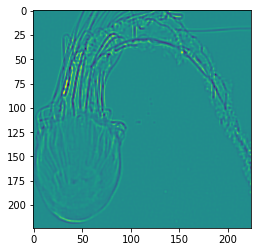

In [8]:
plt.imshow(x_train[0])

In [9]:
def training_data_generator(x_train, y_train):

    # copy arr to 3D
    gray_img = tf.expand_dims(x_train, axis=2)
    gray_img = tf.tile(gray_img, [1,1,3])

    # random crop from 180*180 to 224*224 and resize it  
    rand_int = tf.random.uniform(shape = (), minval=180, maxval=225, dtype=tf.int32, seed=None, name=None)
    gray_img = tf.image.random_crop(gray_img,(rand_int, rand_int,3))
    gray_img = tf.image.resize(gray_img, (224,224))
    gray_img = tf.image.random_flip_left_right(gray_img)
    
    # 0.8% chance to translate img which dx dy from -60 to 60
    dx = tf.random.uniform(shape = (), minval=-60, maxval=61, dtype=tf.int32, seed=None, name=None)
    dy = tf.random.uniform(shape = (), minval=-60, maxval=61, dtype=tf.int32, seed=None, name=None)
    if(tf.random.uniform(shape = (), minval=0, maxval=1, dtype=tf.float32) >= 0.8):
        gray_img = tfa.image.translate(images=gray_img,translations=[dx, dy]) 

#     gray_img = tf.image.random_contrast(gray_img, lower = 0.2, upper = 1.8)
# #     gray_img = tf.image.random_brightness(gray_img, max_delta=30)
#     gray_img = tf.image.random_saturation(gray_img, lower = 0.2, upper = 1.8)

    return gray_img, y_train

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(training_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(x_train.shape[0])
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(training_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(x_val.shape[0])
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

2022-01-20 00:45:29.987922: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1657] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(0, shape=(), dtype=int64)


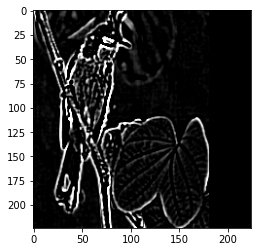

In [11]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][50])
    print(data[1][50])

## model(vgg16)

In [12]:
model = Sequential(name='vgg16')
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=2, activation="softmax"))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                         

## [Important] you should change your check point direction

In [13]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")
loss_fn = tf.losses.SparseCategoricalCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/michael1017/jinyu/comp4/ckpt3',
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
)
callbacks = [
    model_checkpoint_callback,
    tf.keras.callbacks.EarlyStopping(patience=150, monitor = 'val_acc'),
]

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-32GB, compute capability 7.0


In [14]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, callbacks=callbacks, epochs=1000)

Epoch 1/1000


2022-01-20 00:45:37.003563: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f57d000b7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-20 00:45:37.003609: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-20 00:45:37.019121: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-01-20 00:45:38.180162: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2022-01-20 00:45:57.159012: I tensorflow/compiler/jit/xla_compilation_cache.cc:351] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 [==============================] - ETA: 0s - loss: 0.6222 - acc: 0.6264

2022-01-20 00:46:14.261258: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/michael1017/jinyu/comp4/ckpt3/assets
34/34 [==============================] - 42s 552ms/step - loss: 0.6222 - acc: 0.6264 - val_loss: 0.6193 - val_acc: 0.7000
Epoch 2/1000
34/34 [==============================] - 19s 498ms/step - loss: 0.4304 - acc: 0.8166 - val_loss: 0.3491 - val_acc: 0.8781
Epoch 3/1000
34/34 [==============================] - 17s 450ms/step - loss: 0.3836 - acc: 0.8346 - val_loss: 0.3711 - val_acc: 0.8688
Epoch 4/1000
34/34 [==============================] - 17s 436ms/step - loss: 0.3616 - acc: 0.8364 - val_loss: 0.3193 - val_acc: 0.8500
Epoch 5/1000
34/34 [==============================] - 19s 521ms/step - loss: 0.2950 - acc: 0.8773 - val_loss: 0.2713 - val_acc: 0.8813
Epoch 6/1000
34/34 [==============================] - 19s 502ms/step - loss: 0.2828 - acc: 0.8778 - val_loss: 0.2787 - val_acc: 0.8813
Epoch 7/1000
34/34 [==============================] - 20s 535ms/step - loss: 0.2575 - acc: 0.8824 - val_loss: 0.1970 - val_ac

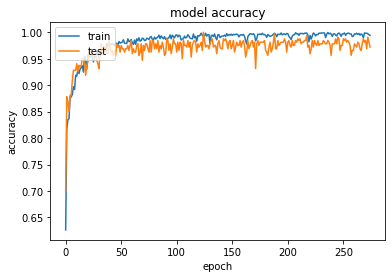

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## infer

In [16]:
x_test = np.load(base_path + 'x_test_imagenet.npy')
x_test = high_pass_filtered(x_test)
x_test = np.expand_dims(x_test, axis=3)
x_test = np.tile(x_test,(1,1,1,3))
print(x_test.shape)
# x_test = np.tile(x_test[])

(100, 224, 224, 3)


## [Important] you should change your check point direction

In [17]:
model = keras.models.load_model('/home/michael1017/jinyu/comp4/ckpt3')

In [18]:
y_pred = model.predict(x_test)

In [19]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)

(100,)


In [20]:
print(y_pred[55])

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


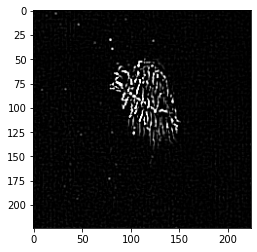

In [21]:
plt.imshow(x_test[55])

In [22]:
pre_df = pd.DataFrame()
for i in range(x_test.shape[0]):
    dic = {'id': int(i), 'label': y_pred[i]}
    pre_df = pre_df.append(dic, ignore_index = True)

In [23]:
print(pre_df.head(10))

    id  label
0  0.0    1.0
1  1.0    0.0
2  2.0    1.0
3  3.0    1.0
4  4.0    1.0
5  5.0    0.0
6  6.0    0.0
7  7.0    1.0
8  8.0    1.0
9  9.0    0.0


## [Important] you should change your output csv direction

In [24]:
pre_df = pre_df.astype(int)
pre_df.to_csv("/home/michael1017/work/data/comp4/imagenet/origin/" + "imgnet_pred_202201180242.csv", encoding = 'utf-8',index = False)